# Validate classification problems
_Lambda School Data Science — Model Validation_ 
Objectives
- Classification Metrics: Precision, Recall, F1, ROC AUC
- Confusion Matrix
- Imbalanced Classes


Reading
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)

## Preliminary setup

#### Install [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
- Google Colab: `pip install category_encoders`
- Local, Anaconda: `conda install -c conda-forge category_encoders`

#### Install  [mlxtend](http://rasbt.github.io/mlxtend/) to plot decision regions
- Google Colab: Already installed
- Local, Anaconda: `conda install -c conda-forge mlxtend`

#### Get the Bank Marketing dataset from Kaggle ...
- Download from the [Kaggle competition page](https://www.kaggle.com/c/ds2-model-validation/data)
- Or use the Kaggle API

#### ... or from GitHub
- Clone the [repo](https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/tree/master/module-1-begin-modeling-process/bank-marketing)
- Or download from the repo:

In [1]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/test_features.csv
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/sample_submission.csv

--2019-03-05 14:37:30--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3833210 (3.7M) [text/plain]
Saving to: ‘train_features.csv’

train_features.csv  100%[===================>]   3.66M  1.74MB/s    in 2.1s    

2019-03-05 14:37:32 (1.74 MB/s) - ‘train_features.csv’ saved [3833210/3833210]

--2019-03-05 14:37:32--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... co

In [2]:
# !pip install category_encoders

# Classification Metrics & Confusion Matrix — with Bank Marketing dataset

In [10]:
# (Code from the previous notebook)

# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
X_train = pd.read_csv('train_features.csv').drop(columns='id')
X_test  = pd.read_csv('test_features.csv').drop(columns='id')
y_train = pd.read_csv('train_labels.csv')['y']
sample_submission = pd.read_csv('sample_submission.csv')

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

#### scikit-learn documentation
- [sklearn.linear_model.LogisticRegression.predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)
- [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.model_selection.cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:, 1]


#### Change the threshold and re-run this cell

In [12]:
threshold = 0.5
y_pred = y_pred_proba >= threshold

print(classification_report(y_train, y_pred))

pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     27411
           1       0.65      0.23      0.34      3480

   micro avg       0.90      0.90      0.90     30891
   macro avg       0.78      0.61      0.64     30891
weighted avg       0.88      0.90      0.88     30891



,Predicted Negative,Predicted Positive
Actual Negative,26990,421
Actual Positive,2690,790


In [13]:
true_negative  = 26990
false_positive = 421
false_negative = 2690
true_positive  = 790

accuracy = ((true_negative + true_positive) / 
            (true_negative + false_positive + false_negative + true_positive))

actual_negative = 26990 + 421
actual_positive = 2690 + 790

predicted_negative = 26990 + 2690
predicted_positive = 421 + 790

precision = true_positive / predicted_positive
recall = true_positive / actual_positive
f1 = 2 * precision*recall / (precision+recall)
print('Precision:', precision, 'Recall:', recall, 'F1:', f1)

Precision: 0.652353426919901 Recall: 0.22701149425287356 F1: 0.3368151780004264


#### ROC Curve
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Area under the Receiver Operating Characteristic curve: 0.7868826100520935


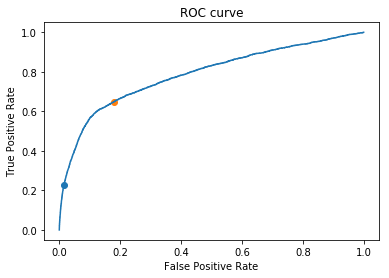

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

# When threshold = 0.5
false_positive = 421
true_positive = 790
false_positive_rate = false_positive/actual_negative
true_positive_rate  = true_positive/actual_positive
plt.scatter(false_positive_rate, true_positive_rate);

# When threshold = 0.1
false_positive = 4946
true_positive = 2258
false_positive_rate = false_positive/actual_negative
true_positive_rate  = true_positive/actual_positive
plt.scatter(false_positive_rate, true_positive_rate);

# Imbalanced Classes — with synthetic data

## Fun demo!

The next code cell does five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [15]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        96
           1       0.36      1.00      0.53         4

   micro avg       0.93      0.93      0.93       100
   macro avg       0.68      0.96      0.75       100
weighted avg       0.97      0.93      0.95       100

accuracy 0.93


,Predicted Negative,Predicted Positive
Actual Negative,89,7
Actual Positive,0,4


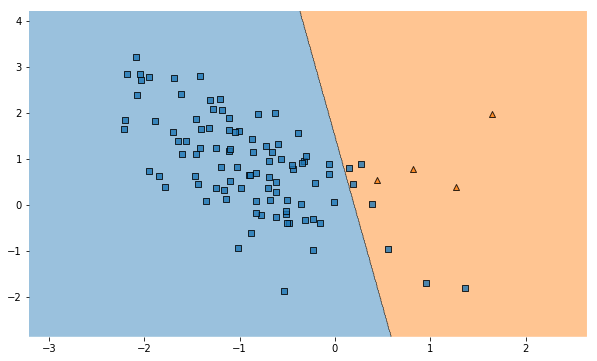

In [16]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = {0: 1, 1: 10}

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))
display(pd.DataFrame(
    confusion_matrix(y_val, y_pred), 
    columns=['Predicted Negative', 'Predicted Positive'], 
    index=['Actual Negative', 'Actual Positive']))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.


#### We demonstrated two of these options: 

- "Adjust the class weight (misclassification costs)" — many scikit-learn classifiers have a `class_balance` parameter
- "Adjust the decision threshold" — you can lean more about this in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

#### Another option to be aware of:
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

# ASSIGNMENT

#### Bank Marketing
- Make another submission on Kaggle.
- Try "Cross-Validation + Independent Test Set" instead of "Train/Validate/Test Split."
- Explore and visualize your data. 
- Wrangle [bad data](https://github.com/Quartz/bad-data-guide), outliers, and missing values.
- Try engineering more features. You can transform, bin, and combine features. 
- Try using less features. You can look at multicollinearity. 
- Try the `class_weight` parameter.

#### Imbalanced Classes demo with synthetic data
- Play around with the demo. Change parameter values.
- Be able to calculate precision, recall, F1, and accuracy "by hand", given a confusion matrix and access to Wikipedia.

In [78]:
# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.metrics import roc_auc_score
import seaborn as sns
import numpy as np

In [21]:
# Baseline Model
################################ 

# Load data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Set X & y - train & test
y_train = train_labels['y']
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')

# Set X & y - train & validation from X & y train
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Training
pipeline.fit(X_train, y_train)
# Training & Validation Prediction
y_pred = pipeline.predict_proba(X_val)[:, 1]
print("roc_auc_score:",roc_auc_score(y_val, y_pred))
print("X_val.shape:",X_val.shape, "X_test.shape:", X_test.shape)

# Train & Test Prediction
y_pred = pipeline.predict_proba(X_test)[:, 1]

# start submission to kaggle
submission = sample_submission.copy()
submission['y'] = y_pred
submission.to_csv('jp-submission-001.csv', index=False) # b/c we don't want to include index value in csv file
# upload submission-001.csv to Kaggle https://www.kaggle.com/c/ds2-model-validation/submit
submission.y.describe()

(23168, 19) (7723, 19) (23168,) (7723,)
roc_auc_score: 0.7926028833929835
X_val.shape: (7723, 19) X_test.shape: (10297, 19)


count    10297.000000
mean         0.112838
std          0.144152
min          0.005984
25%          0.041255
50%          0.058698
75%          0.095619
max          0.894034
Name: y, dtype: float64

In [101]:
# Test 1
# mod:
# drop 'nr.employed'
# add LogisticRegression class_weight='balanced'
################################

# Load data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# age               0.107639
# campaign         -0.058798
# previous          0.035751
# emp.var.rate     -0.144539
# cons.price.idx   -0.023382
# cons.conf.idx     0.081550
# euribor3m        -0.165664
# nr.employed      -8.042919
# y                 0.100303

# Set X & y - train & test
y_train = train_labels['y']
droplist=['id','nr.employed']
X_train = train_features.drop(droplist, axis=1)
X_test  = test_features.drop(droplist, axis=1)

# Set X & y - train & validation from X & y train
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced')
)

# Training
pipeline.fit(X_train, y_train)
# Training & Validation Prediction
y_pred = pipeline.predict_proba(X_val)[:, 1]
print("roc_auc_score:",roc_auc_score(y_val, y_pred))
print("X_val.shape:",X_val.shape, "X_test.shape:", X_test.shape)

# Train & Test Prediction
y_pred = pipeline.predict_proba(X_test)[:, 1]

# start submission to kaggle
submission = sample_submission.copy()
submission['y'] = y_pred
submission.to_csv('jp-submission-002.csv', index=False) # b/c we don't want to include index value in csv file
# upload submission-001.csv to Kaggle https://www.kaggle.com/c/ds2-model-validation/submit
submission.y.describe()

(23168, 18) (7723, 18) (23168,) (7723,)
roc_auc_score: 0.7956902536715622
X_val.shape: (7723, 18) X_test.shape: (10297, 18)


count    10297.000000
mean         0.110818
std          0.141050
min          0.005785
25%          0.041590
50%          0.058457
75%          0.093253
max          0.886942
Name: y, dtype: float64

## Explore Data

In [40]:
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
30684,33,services,single,high.school,unknown,yes,no,cellular,jul,tue,2,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
9314,33,technician,married,professional.course,no,yes,no,cellular,may,wed,1,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1
4861,57,self-employed,married,professional.course,no,yes,yes,telephone,jul,tue,1,999,0,nonexistent,1.4,93.918,-42.7,4.955,5228.1
29556,37,unemployed,married,professional.course,no,no,no,telephone,may,tue,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
29751,47,admin.,married,university.degree,no,no,yes,cellular,aug,mon,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


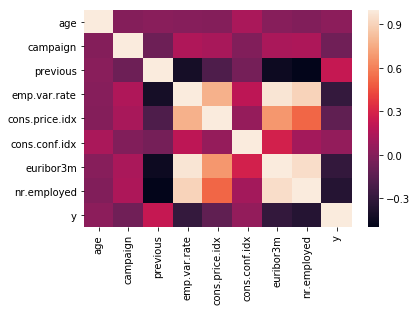

In [75]:
temp=pd.concat([X_train, y_train], axis=1)
sns.heatmap(temp.corr())

In [102]:
print("X_train shape:"), print(X_train.shape), print("---"*20)
print("X_test shape:"), print(X_test.shape), print("---"*20)
print("X_val shape:"), print(X_val.shape), print("---"*20)
print("temp shape:"), print(temp.shape), print("---"*20)
print("temp columns:"), print(temp.columns), print("---"*20)
print("temp select_dtypes(include=[np.number]).columns.values:"), print(temp.select_dtypes(include=[np.number]).columns.values), print("---"*20)
print("temp select_dtypes(exclude=[np.number]).columns:"), print(temp.select_dtypes(exclude=[np.number]).columns), print("---"*20)
print("temp dtypes.sort_values(ascending=False):"), print(temp.dtypes.sort_values(ascending=False)), print("---"*20)
print("temp head().T:"), print(temp.head().T), print("---"*20)
print("temp sample(7).T:"), print(temp.sample(7).T), print("---"*20)
print("temp isnull().sum().sum():"), print(temp.isnull().sum().sum()), print("---"*20)
print("temp isna().sum().sort_values(ascending=False):"), print(temp.isna().sum().sort_values(ascending=False)), print("---"*20)
# nan finder
print("columns[temp.isna().any()].tolist():"), print(temp.columns[temp.isna().any()].tolist()), print("")
# stats data
print("temp corr().T:"), print(temp.corr().T['y']), print("")
print("temp describe(include='all').T:"), print(temp.describe(include='all').T), print("")

X_train shape:
(23168, 18)
------------------------------------------------------------
X_test shape:
(10297, 18)
------------------------------------------------------------
X_val shape:
(7723, 18)
------------------------------------------------------------
temp shape:
(23168, 19)
------------------------------------------------------------
temp columns:
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')
------------------------------------------------------------
temp select_dtypes(include=[np.number]).columns.values:
['age' 'campaign' 'previous' 'emp.var.rate' 'cons.price.idx'
 'cons.conf.idx' 'euribor3m' 'nr.employed' 'y']
------------------------------------------------------------
temp select_dtypes(exclude=[np.number]).columns:
Index(['job', 'marital', 'educa

(None, None, None)

# STRETCH
- Read the blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415). You can replicate the code as-is,  ["the hard way"](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit). Or you can apply it to the Bank Marketing dataset.
- Try the [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library.
- Try other [scikit-learn classifiers](https://scikit-learn.org/stable/supervised_learning.html), beyond Logistic Regression.

In [108]:
# Imports 
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_recall_curve 
from sklearn.preprocessing import LabelEncoder 

# Retrieve Data Set 
df = pd.read_csv('https://raw.githubusercontent.com/srepho/srepho.github.io/master/Churn/churn.txt')

# Some Prepreocessing 
df.columns = [c.lower().replace(' ', '_').replace('?', '').replace("'", "") for c in df.columns] 
state_encoder = LabelEncoder() 
df.state = state_encoder.fit_transform(df.state) 
del df['phone'] 
binary_columns = ['intl_plan', 'vmail_plan', 'churn'] 
for col in binary_columns: 
    df[col] = df[col].map({ 
        'no': 0
    ,   'False.': 0
    ,   'yes': 1
    ,   'True.': 1 
    })

# Build the classifier and get the predictions 
clf = RandomForestClassifier(n_estimators=50, oob_score=True) 
test_size_percent = 0.1 
signals = df[[c for c in df.columns if c != 'churn']] 
labels = df['churn'] 
train_signals, test_signals, train_labels, test_labels = train_test_split(signals, labels, test_size=test_size_percent) 
clf.fit(train_signals, train_labels) 
predictions = clf.predict_proba(test_signals)[:,1]

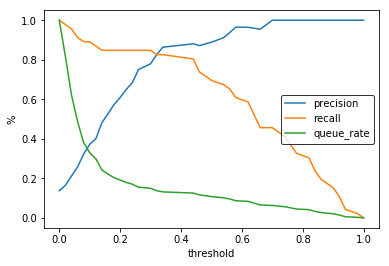

In [113]:
precision, recall, thresholds = precision_recall_curve(test_labels, predictions) 
thresholds = np.append(thresholds, 1) 
queue_rate = [] 
for threshold in thresholds: 
    queue_rate.append((predictions >= threshold).mean()) 
plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
plt.plot(thresholds, recall, color=sns.color_palette()[1])
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
leg.get_frame().set_edgecolor('k') 
plt.xlabel('threshold') 
plt.ylabel('%');